In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [2]:
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [3]:
class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [4]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [5]:
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [6]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data2/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 6583 images belonging to 2 classes.


In [7]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

In [8]:
# '.ipynb_checkpoints' is a *hidden* file Jupyter creates for autosaves
# It must be removed for flow_from_directory to work.
!rmdir /s /q c:data\.ipynb_checkpoints

# Equivalent command in Unix (for Mac / Linux users)
# !rm -r /Users/mikhaillenko/mesonet/mesonet/data/.ipynb_checkpoints/

The system cannot find the file specified.


In [9]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data2/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 6583 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 0s 441ms/step
Predicted likelihood: 0.7081
Actual label: 0
1/1 [==============================] - 0s 57ms/step

Correct prediction: False


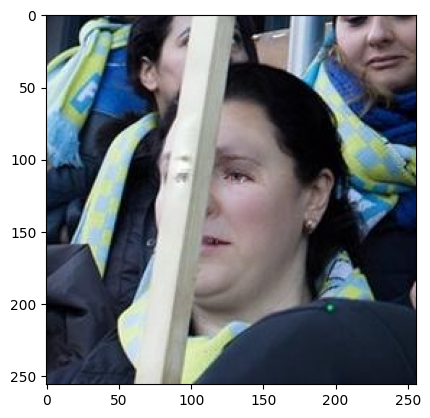

In [10]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [11]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [12]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 37ms/step
0  predictions completed.
1/1 [==============================] - 0s 34ms/step
1000  predictions completed.
1/1 [==============================] - 0s 31ms/step
2000  predictions completed.
1/1 [==============================] - 0s 33ms/step
3000  predictions completed.
1/1 [==============================] - 0s 60ms/step
4000  predictions completed.
1/1 [==============================] - 0s 61ms/step
5000  predictions completed.
1/1 [==============================] - 0s 61ms/step
6000  predictions completed.
1/1 [==============================] - 0s 60ms/step
All 6583 predictions completed


In [13]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show
    return

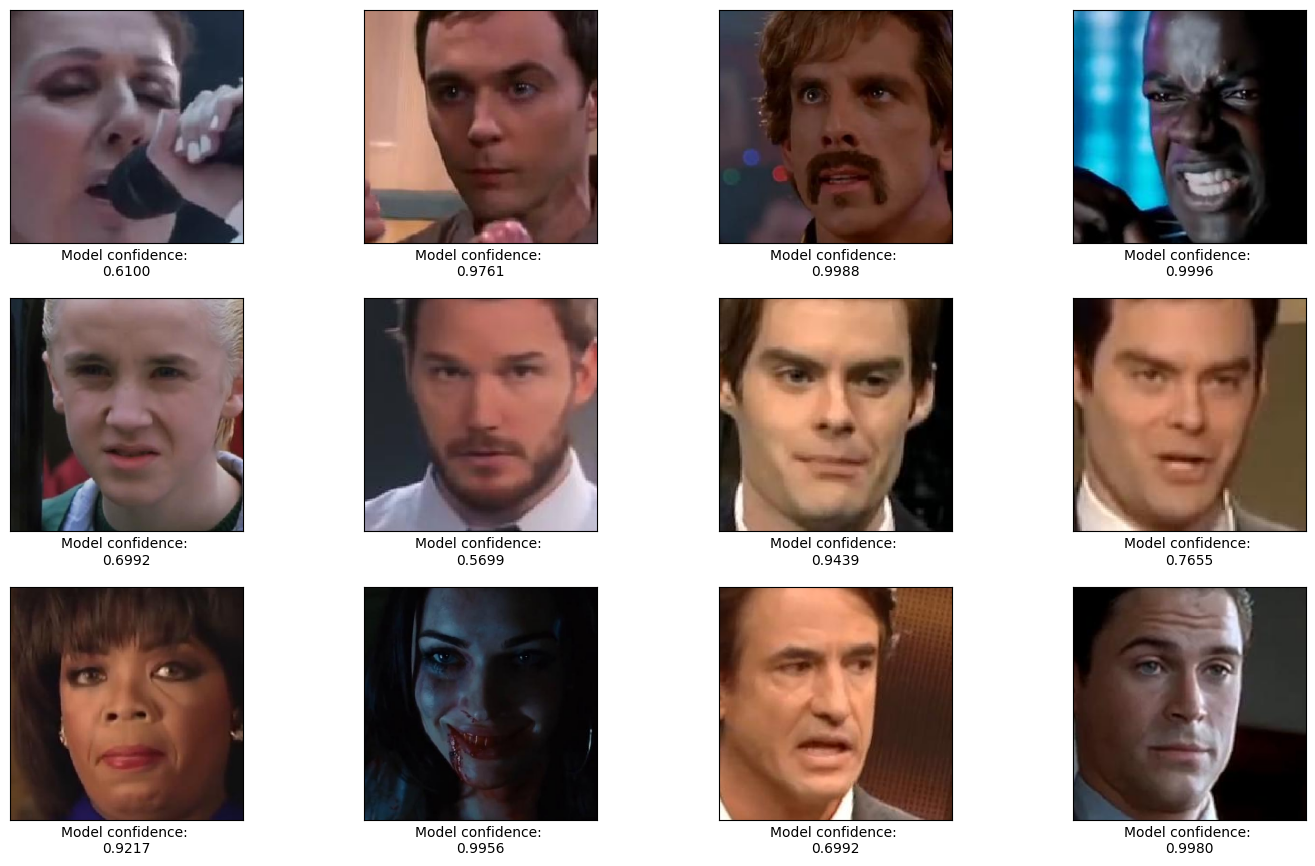

In [14]:
plotter(correct_real, correct_real_pred)

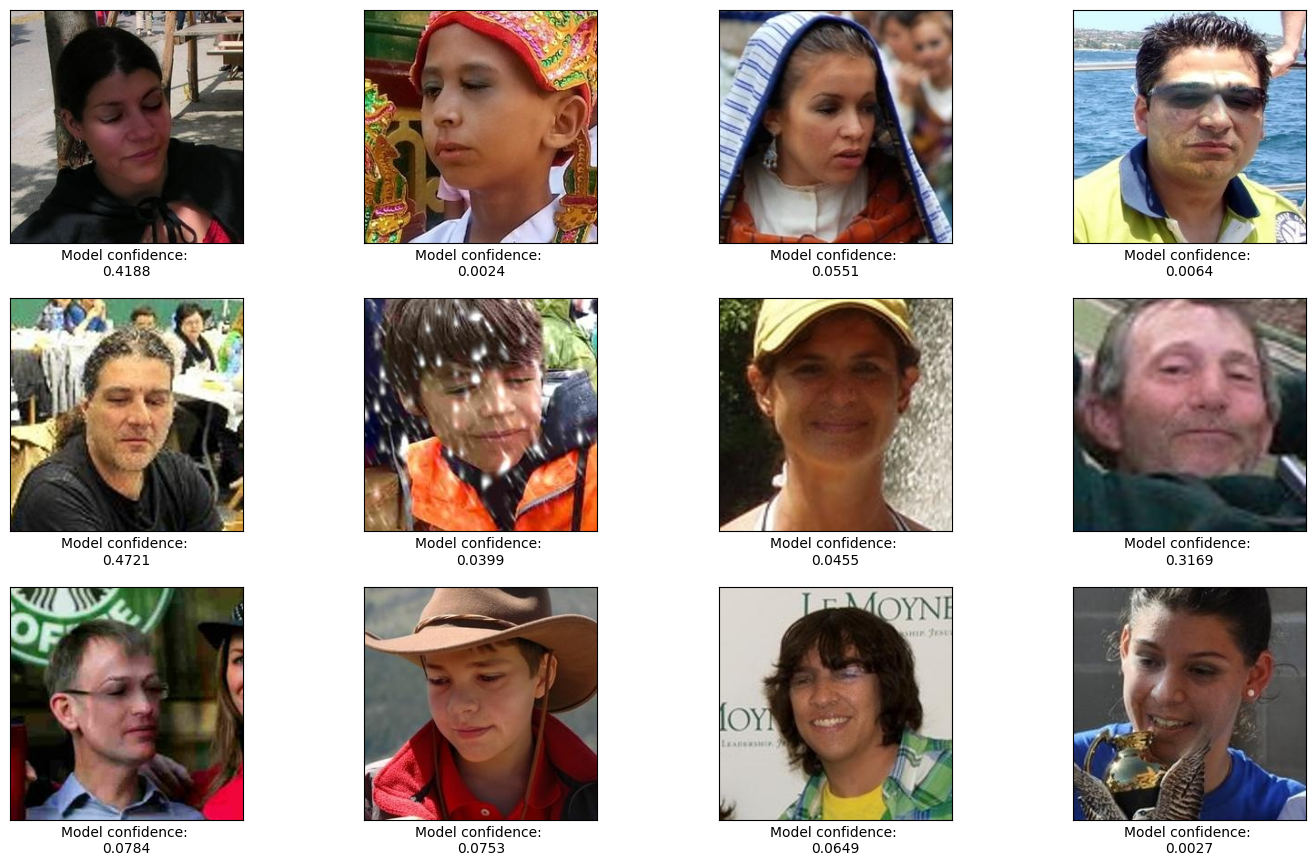

In [15]:
plotter(correct_deepfake, correct_deepfake_pred)

In [11]:
TP = len(correct_real_pred)
TN = len(correct_deepfake_pred)
FP = len(misclassified_deepfake_pred)
FN = len(misclassified_real_pred)

print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)


NameError: name 'correct_real_pred' is not defined

In [34]:
accuracy = (TP + TN) / (TP + TN + FP + FN)

precision = TP / (TP + FP)

recall = TP / (TP + FN)

f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.7959896703630563
Precision: 0.8187581985133362
Recall: 0.8793143930500117
F1 Score: 0.8479565266613834


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.image import resize
def predict(input_image):
    if input_image is None:
        return None  # Return None if no image is provided

    # Define the target size to match your model's input size
    target_size = (256, 256)

    # Resize the input_image to the target size
    input_image = resize(input_image, target_size)

    # Convert the input_image to a format suitable for model prediction
    input_image = image.img_to_array(input_image)
    input_image = np.expand_dims(input_image, axis=0)

    # Make predictions using your Meso4 model
    prediction = meso.predict(input_image)
    rounded_prediction = round(prediction[0][0])
    
    return rounded_prediction

# Create a Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[gr.inputs.Image(type="pil", label="Upload an image for deep fake detection")],
    outputs="number",
    live=True,
    title="Deep Fake Detection",
    description="Upload an image for deep fake detection. <br> 0: DeepFake <br> 1: Real ",
)

if __name__ == "__main__":
    iface.launch()

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


IMPORTANT: You are using gradio version 3.0, however version 3.14.0 is available, please upgrade.
--------
Hint: Set streaming=True for Image component to use live streaming.
Running on local URL:  http://127.0.0.1:7864/

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 69ms/step


In [14]:
#Not correct

import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.image import resize

# Define a function to preprocess and make predictions based on user input

def predict(input_image):
    if input_image is None:
        return None  # Return None if no image is provided

    # Define the target size to match your model's input size
    target_size = (256, 256)

    # Resize the input_image to the target size
    input_image = resize(input_image, target_size)

    # Convert the input_image to a format suitable for model prediction
    input_image = image.img_to_array(input_image)
    input_image = np.expand_dims(input_image, axis=0)

    # Make predictions using your Meso4 model
    prediction = meso.predict(input_image)
    
    # Round the prediction to the nearest integer (0 or 1)
    rounded_prediction = round(prediction[0][0])
    
    return rounded_prediction



# Create a Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[gr.inputs.Image(type="pil", label="Upload an image for deep fake detection")],
    outputs="text",  # Specify text output for the label
    live=True,
    title="Meso4 Deep Fake Detection",
    description="Upload an image for deep fake detection.",
)

if __name__ == "__main__":
    iface.launch()

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


IMPORTANT: You are using gradio version 3.0, however version 3.14.0 is available, please upgrade.
--------
Hint: Set streaming=True for Image component to use live streaming.
Running on local URL:  http://127.0.0.1:7862/

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 68ms/step
